In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
pip install wget

In [ ]:
import json
import cv2
from google.colab.patches import cv2_imshow
import wget

# Download COCO stuff Annotations

In [ ]:
import os

os.chdir('/content/drive/My Drive/AIVC/Flood_Dataset/COCO_stuff')
os.getcwd()

In [ ]:
# !wget http://calvin.inf.ed.ac.uk/wp-content/uploads/data/cocostuffdataset/stuff_trainval2017.zip

--2022-04-16 04:59:44--  http://calvin.inf.ed.ac.uk/wp-content/uploads/data/cocostuffdataset/stuff_trainval2017.zip
Resolving calvin.inf.ed.ac.uk (calvin.inf.ed.ac.uk)... 129.215.202.26
Connecting to calvin.inf.ed.ac.uk (calvin.inf.ed.ac.uk)|129.215.202.26|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://calvin.inf.ed.ac.uk/wp-content/uploads/data/cocostuffdataset/stuff_trainval2017.zip [following]
--2022-04-16 04:59:45--  https://calvin.inf.ed.ac.uk/wp-content/uploads/data/cocostuffdataset/stuff_trainval2017.zip
Connecting to calvin.inf.ed.ac.uk (calvin.inf.ed.ac.uk)|129.215.202.26|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://calvin-vision.net/wp-content/uploads/data/cocostuffdataset/stuff_trainval2017.zip [following]
--2022-04-16 04:59:45--  https://calvin-vision.net/wp-content/uploads/data/cocostuffdataset/stuff_trainval2017.zip
Resolving calvin-vision.net (calvin-vision.net)... 66

In [ ]:
# from zipfile import ZipFile
# zf = ZipFile('./stuff_trainval2017.zip', 'r')
# zf.extractall('./')
# zf.close()

# Read Files

In [ ]:
JsonFilePath=os.path.join(os.getcwd(), "stuff_train2017.json")

with open(JsonFilePath) as f:
     TrainLabels = json.load(f)

In [ ]:
TrainLabels.keys()

dict_keys(['info', 'images', 'licenses', 'categories', 'annotations'])

In [ ]:
TrainLabels['images']

In [ ]:
TrainLabels['categories']

In [ ]:
WaterSuperCat = [i for i in TrainLabels['categories'] if i['supercategory']=='water']

[i for i in WaterSuperCat if i['name'] in ['river', 'sea', 'water-other']]

[{'id': 148, 'name': 'river', 'supercategory': 'water'},
 {'id': 155, 'name': 'sea', 'supercategory': 'water'},
 {'id': 178, 'name': 'water-other', 'supercategory': 'water'}]

In [ ]:
dict_river = [obj for obj in TrainLabels['annotations'] if obj['category_id']==148]

river_image_IDs = [i['image_id'] for i in dict_river]
print(len(river_image_IDs))

imgURL_river = [[img['coco_url'], img['id']] for img in TrainLabels['images'] if img['id'] in river_image_IDs]

# for i in imgURL_river:
#   filename = wget.download(i[0], out='./COCOstuffImages')

2313


In [ ]:
dict_sea = [obj for obj in TrainLabels['annotations'] if obj['category_id']==155]

sea_image_IDs = [i['image_id'] for i in dict_sea]
print(len(sea_image_IDs))

imgURL_sea = [[img['coco_url'], img['id']] for img in TrainLabels['images'] if img['id'] in sea_image_IDs]

# for i in imgURL_sea:
#   filename = wget.download(i[0], out='./COCOstuffImages')    # To Do

6598


In [ ]:
dict_water = [obj for obj in TrainLabels['annotations'] if obj['category_id']==178]

water_image_IDs = [i['image_id'] for i in dict_water]
print(len(water_image_IDs))

imgURL_water = [[img['coco_url'], img['id']] for img in TrainLabels['images'] if img['id'] in water_image_IDs]

# for i in imgURL_sea:
#   filename = wget.download(i[0], out='./COCOstuffImages')     # To Do

2453


In [ ]:
AllWaterImages_ID = list(set(river_image_IDs + sea_image_IDs + water_image_IDs))
len(AllWaterImages_ID)

10941

In [ ]:
TrainLabelsAllWater = [objdict for objdict in TrainLabels['annotations'] if objdict['image_id'] in AllWaterImages_ID] 

In [ ]:
# with open("COCOStuffWater.json", "w") as outfile: 
#     json.dump(TrainLabelsAllWater, outfile)

# Visualize Dataset

In [ ]:
!wget imgURL -q -O input.jpg

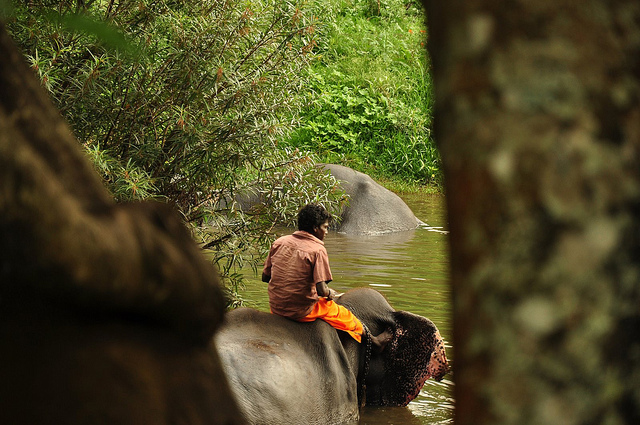

In [ ]:
im = cv2.imread(filename)
cv2_imshow(im)

In [ ]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

In [ ]:
MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

Metadata(evaluator_type='coco', image_root='datasets/coco/train2017', json_file='datasets/coco/annotations/instances_train2017.json', name='coco_2017_train', thing_classes=['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy b

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset", {}, "stuff_train2017.json", "./")

In [ ]:
metadata = MetadataCatalog.get("my_dataset")

In [ ]:
# img = cv2.imread(d["file_name"])
visualizer = Visualizer(im, metadata=metadata, scale=1)

In [ ]:
Train_dataset_dicts = DatasetCatalog.get("my_dataset")

[04/16 05:43:44 d2.data.datasets.coco]: Loading stuff_train2017.json takes 15.61 seconds.
WARNING [04/16 05:43:44 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/16 05:43:45 d2.data.datasets.coco]: Loaded 118287 images in COCO format from stuff_train2017.json


In [ ]:
[i for i in Train_dataset_dicts if i['image_id']==384553][0]

{'annotations': [{'bbox': [0.0, 0.0, 454.0, 275.0],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 50,
   'iscrowd': 0,
   'segmentation': {'counts': '0Q1X<000000001O001O00000000001O3M3M5K1O1O000000O11O0000O1001O0_D`NJ1\\;`1iD_NL031Q;a1nD`NM11NT;b1nDcNMLU;a1PEfNo:\\1PEdNo:\\1PEgNn:k1SEjMe:]20001O004LO100002N2N009G1O0000001O1O1O001O00003nEjLk9`3J1O1O5_FYLV9m30001O001O001O0000002N006J6J00001OO11O1OO12N1O1O3]GYK40T8i4jGZKU8g4jGZKU8n4O00002N000mGlJ31M1g7U5YHSKd7X511O1OO100001O000000001O>B1O0000O11O000000001O0000004L:F1O1O00O1000000O100000000O11O00J6F:1ON200O1001O001O0000000000O11O00000000001O001ONnHmIR7S620000O11OO11OO11oHmIj6Y6RIgIl6^6M1O0000001O000000001iI_Id5`6]JaIb5_6^J`Ic5a6XJ`IE0O4l5o6TJRIk5W7O2N1O1O001O0000O\\J_Hb5a7^J`Ha5\\6_JcJ0ROa5[6`JcJNQOc5[6bJeJ^5[5cJeJLoN\\5[6jJgJHPO\\5Y6lJkJT5T5mJmJR5S5nJmJR5R5oJnJQ5R5oJnJQ5Q5PKoJP5Q5PKoJP5P5QKQKn4o4RKQKn4n4SKSKl4m4TKSKl4l4UKSKl4m4UKRKLiNb4T6cKTKDTOc4h5iKXK@PO0De4S6lKiKT4W4lKhKU4W4lKjKS4V4mKjKS4U4nKkKR4U4nKkKR4T4oKlKQ4T4oKkKR4T4oKl

In [ ]:
Train_dataset_dicts

In [ ]:
out = visualizer.draw_dataset_dict([i for i in Train_dataset_dicts if i['image_id']==384553][0])


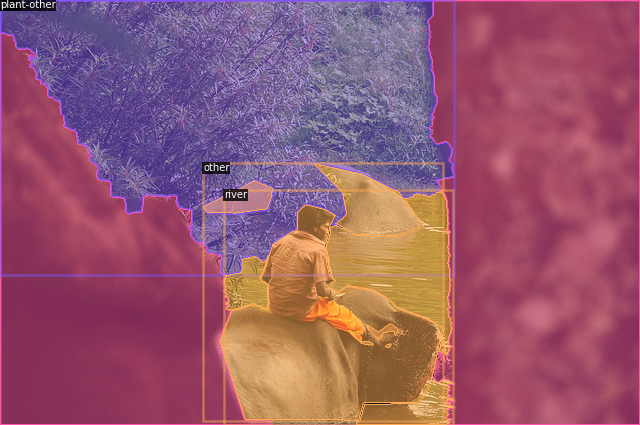

In [ ]:
cv2_imshow(out.get_image())

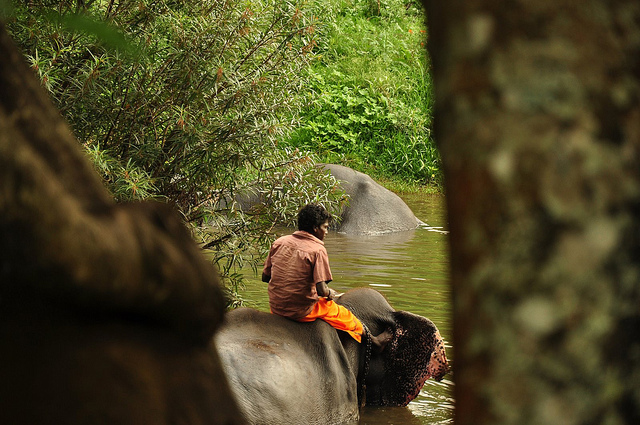

In [ ]:
cv2_imshow(im)